<a href="https://colab.research.google.com/github/afhabibieee/chest-xray-covid19-pneumonia/blob/main/chest_xray_covid19_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries

In [ ]:
# Download All Dependencies
!pip install -q kaggle

# updating (server 1.5.12 / client 1.5.4)
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=72045d0985c5167666177e4c5b9533a9a22d3baff44985279b3edf39b54b39c3
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


## Data Collection

In [ ]:
# Upload API Files from Kaggle
from google.colab import files
files.upload()

In [ ]:
# Connect Collab to Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
# Searching spam datasets
! kaggle datasets list -s Chest

ref                                                          title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
paultimothymooney/chest-xray-pneumonia                       Chest X-Ray Images (Pneumonia)                2GB  2018-03-24 19:41:59         152260       4692  0.75             
nih-chest-xrays/data                                         NIH Chest X-rays                             42GB  2018-02-21 20:52:23          57048        889  0.7352941        
bachrr/covid-chest-xray                                      COVID-19 chest xray                         241MB  2020-05-15 00:30:50           9163        210  0.9411765        
praveengovi/coronahack-chest-xraydataset                     CoronaHack -Chest X-Ray-Dataset               1GB  202

In [ ]:
# download dataset chest-xray-covid19-pneumonia from prashant268
!kaggle datasets download "prashant268/chest-xray-covid19-pneumonia"

100% 2.05G/2.06G [01:07<00:00, 47.9MB/s]
100% 2.06G/2.06G [01:07<00:00, 32.7MB/s]


In [ ]:
# unzip dataset
!unzip -qq chest-xray-covid19-pneumonia.zip

## Data Preprocessing

In [ ]:
# class dataset
import os
os.listdir('/content/Data/train')

['COVID19', 'PNEUMONIA', 'NORMAL']

In [ ]:
train_dir = '/content/Data/train'
test_dir = '/content/Data/test'

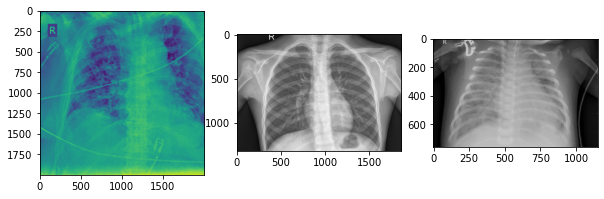

In [ ]:
# show pictures for each class
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

cov_img = Image.open(train_dir+'/COVID19/COVID19(0).jpg')
norm_img = Image.open(train_dir+'/NORMAL/NORMAL(0).jpg')
pneu_img = Image.open(train_dir+'/PNEUMONIA/PNEUMONIA(0).jpg')

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(cov_img)
ax[1].imshow(norm_img)
ax[2].imshow(pneu_img)
fig.show()

In [ ]:
# displaying the dimensions / check image size
wid, hgt = cov_img.size
print(str(wid) + "x" + str(hgt))

2000x2000


In [ ]:
# set image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

batch_size = 32   # set batch size

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'grayscale'
)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
(test_generator.samples/(test_generator.samples+train_generator.samples)) * 100   # percentage of data testing

20.024875621890548

## Modeling

In [ ]:
# import required library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='swish', input_shape=(256,256,1)),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3), activation='swish'),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3), activation='swish'),
    MaxPooling2D(2,2),
    Conv2D(256,(3,3), activation='swish'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation= 'relu'),
    Dense(3, activation= 'softmax')
])

In [ ]:
# compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import  EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               mode='max')

In [ ]:
# train model
import math

history = model.fit(
    train_generator,
    steps_per_epoch = math.ceil(train_generator.samples//batch_size),
    epochs = 25,
    validation_data = test_generator,
    validation_steps = math.ceil(test_generator.samples//batch_size),
    callbacks=[early_stopping],
    use_multiprocessing=True
)

Epoch 1/25
160/160 [==============================] - 968s 6s/step - loss: 0.4966 - accuracy: 0.7973 - val_loss: 0.2612 - val_accuracy: 0.9187
Epoch 2/25
160/160 [==============================] - 962s 6s/step - loss: 0.2759 - accuracy: 0.8993 - val_loss: 0.2967 - val_accuracy: 0.8969
Epoch 3/25
160/160 [==============================] - 972s 6s/step - loss: 0.2262 - accuracy: 0.9169 - val_loss: 0.1763 - val_accuracy: 0.9359
Epoch 4/25
160/160 [==============================] - 973s 6s/step - loss: 0.1925 - accuracy: 0.9313 - val_loss: 0.1868 - val_accuracy: 0.9344
Epoch 5/25
160/160 [==============================] - 974s 6s/step - loss: 0.1761 - accuracy: 0.9374 - val_loss: 0.1607 - val_accuracy: 0.9375
Epoch 6/25
160/160 [==============================] - 977s 6s/step - loss: 0.1670 - accuracy: 0.9399 - val_loss: 0.1256 - val_accuracy: 0.9508
Epoch 7/25
160/160 [==============================] - 980s 6s/step - loss: 0.1698 - accuracy: 0.9362 - val_loss: 0.1516 - val_accuracy: 0.9414

## Model Evaluation

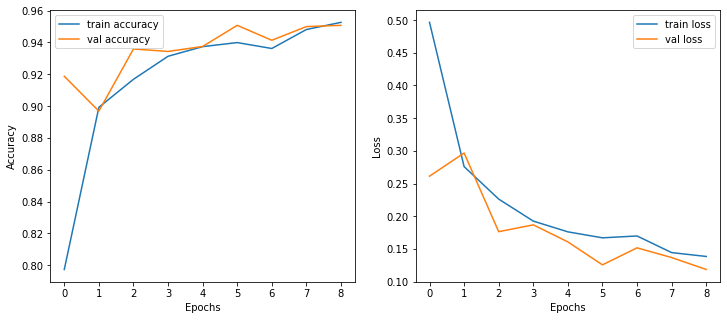

In [ ]:
# ploting accuracy and loss

fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(history.history['accuracy'], label='train accuracy')
axs[0].plot(history.history['val_accuracy'], label='val accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[1].plot(history.history['loss'], label='train loss')
axs[1].plot(history.history['val_loss'], label='val loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')
axs[0].legend()
axs[1].legend()
fig.show()

In [ ]:
# test data evaluation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np

n_batches = len(test_generator)

print(classification_report(
    np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]),    
    np.argmax(model.predict(test_generator, steps=n_batches), axis=1)
))

print('\n')

print(confusion_matrix(
    np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)]),    
    np.argmax(model.predict(test_generator), axis=1)
))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       116
           1       0.89      0.95      0.92       317
           2       0.98      0.95      0.96       855

    accuracy                           0.95      1288
   macro avg       0.94      0.95      0.95      1288
weighted avg       0.95      0.95      0.95      1288



[[110   2   4]
 [  0 301  16]
 [  4  37 814]]


## Preparing for Deployment

In [ ]:
import tensorflow as tf
import pathlib
import os

### TF-Lite

In [ ]:
# save the model in SaveModel . format
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# convert SavedModel to vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('covnormpneu.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


104325588

In [ ]:
# label of the dataset used
%%writefile covnormpneu.txt
COVID19
NORMAL
PNEUMONIA

Writing covnormpneu.txt


### TF-Serving

In [ ]:
model.save('model_CNP.h5')
modelCNP = tf.keras.models.load_model('model_CNP.h5')
save_path = os.path.join("models/cnp_model/1/")
save(model, save_path)

INFO:tensorflow:Assets written to: models/cnp_model/1/assets


INFO:tensorflow:Assets written to: models/cnp_model/1/assets


In [ ]:
# compress the folder to be downloaded to a local computer
!zip -r /content/modelCovNormPneu.zip /content/models

updating: content/models/ (stored 0%)
updating: content/models/cnp_model/ (stored 0%)
updating: content/models/cnp_model/1/ (stored 0%)
updating: content/models/cnp_model/1/variables/ (stored 0%)
updating: content/models/cnp_model/1/variables/variables.data-00000-of-00001 (deflated 6%)
updating: content/models/cnp_model/1/variables/variables.index (deflated 66%)
updating: content/models/cnp_model/1/saved_model.pb (deflated 90%)
updating: content/models/cnp_model/1/assets/ (stored 0%)
